# Assignment 3: Is Science Becoming Less Disruptive?

>Ioanna Moraiti <br />
>AM: 8190121 <br />
>Email: t8190121@aueb.gr

Για να υπολογιστεί κατά πόσο ένα ερευνητικό έργο καινοτομεί στον τομέα του μπορεί να υπολογιστεί ένας δείκτης σύμφωνα με το πόσα μετεγεννέστερα έργα έχουν αναφορά στο συγκεκριμένο paper. Ο δείκτης αυτός ονομάζεται CD Index και αν μετριέται σε διάστημα πέντε ετών CD5. Πάνω σε αυτόν τον δείκτη βασίστηκε και το [άρθρο στο περιοδικό Nature](https://www.nature.com/articles/s41586-022-05543-x) για να δείξει την αλλαγή στα επίπεδα καινοτομίας ανά τα χρόνια. Υπάρχει όμως τρόπος υπολογισμού αυτού του δείκτη άμεσα; Σκοπός αυτής της εργασίας είναι η δημιουργία μοντέλων μηχανικής μάθησης για τον υπολογισμό του δείκτη CD5 ανάλογα με τα διάφορα χαρακτηριστικά ενός paper.

## Data formatting

* Αρχικά κάνουμε import όλες τις βιβλιοθήκες που θα χρησιμοποιήσουμε

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import sqlite3

C:\Users\Ioann\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


* Παίρνουμε τα δεδομένα μας από τη βάση δεδομένων `publications_graph`. Επειδή ο πίνακας με τον δείκτη CD5 `cdindex` περιέχει πολλά παραπάνω στοιχεία από ότι οι υπόλοιποι πίνακες που συνδέονται με τον βασικό πίνακα `works` διαγράφουμε τα περιττά papers ώστε να επιταχύνουμε την διαδικασία
* Στη συνέχεια διαβάζουμε τα στοιχεία και τα αποθηκεύουμε σε αντίστοιχα DataFrames ώστε να επιλεγούν τα τελικά features που θα χρησιμοποιήσουμε στο μοντέλο
* Αφαιρούνται οι συγγραφείς και τα αντίστοιχα υδρίματα που εκπροσωπούν πολύ μικρό ποσοστό από papers. Συγκεκριμένα, επιλέχτηκαν συγγραφείς που έχουν δημοσιεύσει πάνω από 5 papers και τα υδρίματα που εκπροσωπούν πάνω από 5 συγγραφείς. Για αυτούς τους συγγραφείς και υδρίματα δημιουργούνται dummy στήλες
* Στη συνέχεια υπολογίζεται ο μέσος όρος των χρονολογιών των references 
* Τέλος προστίθενται τα subjects. Κρατάμε τα subjects που χαρακτηρίζουν πάνω από 300 και λιγότερα από 2000 papers καθώς σε αυτά περιέχεται η πλειοψηφία. Τα υπόλοιπα θεωρούνται outliers και αφαιρούνται. Όπως και προηγουμένος, δημιουργούνται dummy στήλες

Ενώνουμε όλα τα DataFrames στο τελικό DataFrame `works`. Σαν features στα μοντέλα μας θα χρησιμοποιηθούν οι επιλεγμένοι συγγραφείς, τα υδρίματά τους, ο μέσος όρος χρονολογίας των references, το αντικείμενο κάθε paper, το abstract, ο τίτλος και τα διάφορα στοιχεία που σχετίζονται με τη χρονολογία που εκδόθηκε.

In [2]:
try:

    # Connect to DB and create a cursor
    sqliteConnection = sqlite3.connect('publications_graph.db')
    print('DB Init')

    # Create a cursor object
    cursor = sqliteConnection.cursor()

    # Execute a DELETE statement
    cursor.execute('DELETE FROM cdindex WHERE cdindex.doi NOT IN (SELECT doi FROM works)')
    sqliteConnection.commit()

    # Write a query and save results into pandas DataFrame
    query_works = 'SELECT * FROM works'
    query_cdindex = 'SELECT * FROM cdindex'
    query_author_affiliations = 'SELECT * FROM author_affiliations'
    query_work_authors = 'SELECT * FROM work_authors'
    query_work_references = 'SELECT * FROM work_references'
    query_work_subjects = 'SELECT * FROM work_subjects'

    # Create separate DataFrames
    works = pd.read_sql_query(query_works, sqliteConnection)
    cdindex = pd.read_sql_query(query_cdindex, sqliteConnection)  # Target
    author_affiliations = pd.read_sql_query(query_author_affiliations, sqliteConnection)
    work_authors = pd.read_sql_query(query_work_authors, sqliteConnection)
    work_references = pd.read_sql_query(query_work_references, sqliteConnection)  # Median of year
    work_subjects = pd.read_sql_query(query_work_subjects, sqliteConnection)  # Modeled with 0 or 1

    # Merge and aggregate them in a single DataFrame
    # Authors
    # Only keep authors with orcid
    work_authors.dropna(subset=['orcid'], inplace=True)
    # Merge
    work_authors = pd.merge(work_authors, author_affiliations, left_on='id', right_on='author_id', how='left')
    work_authors.drop(columns=['id', 'author_id'], inplace=True)  # Drop unecessary columns
    # Remove outlier authors
    authors = work_authors['orcid'].value_counts()
    work_authors = work_authors[work_authors['orcid'].isin(authors[authors > 5].index)]
    # Remove outlier affiliations
    aff = work_authors['name'].value_counts()
    work_authors.loc[work_authors['name'].isin(aff[aff < 4].index), 'name'] = None
    # Create dummies
    work_authors.set_index('work_id')
    work_authors = pd.get_dummies(work_authors, prefix='', columns=['orcid', 'name'])
    work_authors = work_authors.groupby('work_id').sum().reset_index()
    # Merge and create dummies
    works = pd.merge(works, work_authors, left_on='id', right_on='work_id', how='left')
    works.drop(columns=['work_id'], inplace=True)

    # References year
    work_references.drop(columns=['article_title', 'doi'], inplace=True)
    work_references.dropna(subset=['year'], inplace=True)
    work_references = work_references[work_references['year'].str.isnumeric()]
    work_references = work_references.astype({'year': int})
    work_references = work_references.groupby('work_id').agg('mean').reset_index()
    work_references = work_references.astype({'year': int})
    work_references.rename(columns={'year': 'ref_year'}, inplace=True)
    works = pd.merge(works, work_references, left_on='id', right_on='work_id', how='left')
    works.drop(columns=['work_id'], inplace=True)

    # Subjects
    work_subjects.rename(columns={'name': 'subject'}, inplace=True)
    subjects = work_subjects['subject'].value_counts()
    work_subjects = work_subjects[work_subjects['subject'].isin(subjects[(subjects > 300) & (subjects < 2000)].index)]
    work_subjects = pd.get_dummies(work_subjects, prefix='subject')
    work_subjects = work_subjects.groupby('work_id').sum().reset_index()
    works = pd.merge(works, work_subjects, left_on='id', right_on='work_id', how='left')
    works.drop(columns=['work_id'], inplace=True)

    # Target
    works = pd.merge(works, cdindex, on='doi')

# Handle errors
except sqlite3.Error as error:
    print('Error occurred - ', error)

# Close DB Connection irrespective of success
# or failure
finally:

    if sqliteConnection:
        sqliteConnection.close()
        print('SQLite Connection closed')


DB Init
SQLite Connection closed


## Decision Tree model

* Εφώσον θέλουμε να υπολογίσουμε μια συνεχή αριθμητική τιμή θα φτιάξουμε ένα μοντέλο regression
* Αφαιρούμε από το DataFrame `works` τις στήλες με κατηγορικά δεδομένα

In [3]:
works_nn = works.drop(columns=['id', 'title', 'doi'])
works.drop(columns=['abstract', 'id', 'title', 'doi'], inplace=True)

* Γεμίζουμε με 0 τις NaN τιμές και χωρίζουμε το DataFrame σε training και testing

In [4]:
works.fillna(0, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(works.iloc[:, :-1],
                                                    works['cdindex'],
                                                    test_size=0.25,
                                                    random_state=42)

* Βλέπουμε πως οι στήλες έχουν πολύ διαφορετικές διακυμάνσεις. Θέλοντας να αποφύγουμε την κανονικοποίηση θα χρησιμοποιήσουμε ένα μοντέλο regression με decision tree

In [5]:
works.describe()

,published_month,published_day,published_year,_0000-0001-5034-1135,_0000-0001-5114-6534,_0000-0001-5401-2996,_0000-0001-5576-636X,_0000-0001-5596-9853,_0000-0001-5647-6938,_0000-0001-5722-1347,...,subject_Statistics and Probability,"subject_Statistics, Probability and Uncertainty",subject_Strategy and Management,"subject_Surfaces, Coatings and Films",subject_Surgery,subject_Urban Studies,subject_Virology,subject_Visual Arts and Performing Arts,subject_Water Science and Technology,cdindex
count,137641.000000,137641.000000,137641.000000,137641.000000,137641.000000,137641.000000,137641.000000,137641.000000,137641.000000,137641.000000,...,137641.000000,137641.000000,137641.000000,137641.000000,137641.000000,137641.000000,137641.000000,137641.000000,137641.000000,137641.000000
mean,6.283179,9.386774,2011.500360,0.000058,0.000073,0.000036,0.000036,0.000073,0.000065,0.000073,...,0.007418,0.004563,0.007396,0.003168,0.010251,0.002260,0.004330,0.002209,0.003952,0.132222
std,4.029692,10.531503,12.332147,0.015248,0.019059,0.013477,0.006027,0.019059,0.017259,0.019059,...,0.085807,0.067501,0.086358,0.056193,0.100873,0.047633,0.065661,0.046944,0.062743,0.340194
min,0.000000,0.000000,1945.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000
25%,3.000000,0.000000,2008.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,6.000000,4.000000,2016.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,10.000000,18.000000,2020.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,12.000000,31.000000,2021.000000,4.000000,5.000000,5.000000,1.000000,5.000000,5.000000,5.000000,...,1.000000,2.000000,2.000000,1.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000


* Επιλέγουμε το `DecesionTreeRegressor` της βιβλιοθήκης `sklearn` και το κάνουμε fit σύμφωνα με το training DataFrame
* Στο σημείο αυτό πρέπει να εξετάσουμε ποιο είναι το ιδανικό max_depth ώστε να υπολογίζεται η τιμή με επιτυχία, όμως να αποφεύγεται το φαινόμενο του overfit και το μοντέλο να μην επηρεάζεται από τον θόρυβο

In [6]:
works_tree = DecisionTreeRegressor(max_depth=13)
works_tree.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=13)

* Θα κάνουμε Cross Validation με `GridSearch` για να βρούμε το ιδανικό `max_depth`

DecisionTreeRegressor(max_depth=11)
{'max_depth': 11}


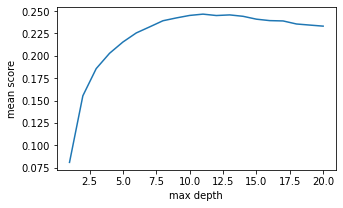

In [7]:
parameters = [
  {'max_depth': list(range(1, 21))},
 ]

cv = KFold(n_splits=5, shuffle=True, random_state=13)
clf = GridSearchCV(DecisionTreeRegressor(), parameters, cv=cv)

clf = clf.fit(X_train, y_train)
print(clf.best_estimator_)
print(clf.best_params_)

cv_results = pd.DataFrame(clf.cv_results_)
plt.figure(figsize=(5, 3))
plt.plot(cv_results['param_max_depth'], cv_results['mean_test_score'], label='True y')
plt.xlabel('max depth')
_ = plt.ylabel('mean score')
plt.show()

* Βλέπουμε ότι σωστά έχει επιλεχτεί το νούμερο 13
* Σε εναλλακτική προσέγγιση θα μπορούσαμε να είχαμε εκτελέσει ένα feature selection για να αφαιρέσουμε τις περιττές στήλες
* Κάνουμε την πρόβλεψη και βλέπουμε το Mean Absolute Error

In [8]:
predicted = works_tree.predict(X_test)
print(f'MAE={metrics.mean_absolute_error(y_test, predicted)}')

MAE=0.16886544093960645


Άρα το μοντέλο που φτιάξαμε υπολογίζει τον δείκτη CD5 με μέση απόκλιση 0.17

## Neural Network model

* Η δεύτερη προσέγγιση που θα δοκιμάσουμε θα είναι με Νευρωνικό Δίκτυο, χρησιμοποιώντας τη βιβλιοθήκη `TensorFlow`
* Αρχικά θα επεξεργαστούμε το abstract των papers
    * Θα κάνουμε όλους τους χαρακτήρες lowercase
    * Θα αφαιρέσουμε περιτά σύμβολα και
    * Θα εφαρμόσουμε ένα `TextVectorization` layer

In [9]:
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, r'^(<).*(>)$', '')
    
    return tf.strings.regex_replace(stripped_html,
                                    '[%s]' % re.escape(string.punctuation),
                                    '')
max_features = 20000

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode="multi_hot"
)
vectorize_layer.adapt(works_nn['abstract'])
works_nn['abstract'] = works_nn['abstract'].apply(
    lambda x: (vectorize_layer(x)))

* Στη συνέχεια, επειδή χρησιμοποιούμε Νευρωνικά Δίκτυα, θα κανονικοποιήσουμε τα δεδομένα μας με έναν `MinMax` scaler
* Τα vectors που δημιουργήσαμε στο προηγούμενο βήμα δεν έχει νόημα να κανονικοποιηθούν, επομένως προστίθενται στο τέλος

In [10]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
works = pd.DataFrame(scaler.fit_transform(works), columns=works.columns)
works['abstract'] = works_nn['abstract']

* Χωρίζουμε το DataFrame σε training και testing όπως προηγουμένως

In [11]:
X_train, X_test, y_train, y_test = train_test_split(works.iloc[:, :-1],
                                                    works['cdindex'],
                                                    test_size=0.25,
                                                    random_state=42)

* Χτίζουμε το μοντέλο που θα εκπαιδευτεί
* Το μοντέλο αποτελέιται από τρία dense στρώματα που έχουν σαν output την τελική τιμή υπολογισμού του CD5

In [12]:
def build_compile_model():
    model = keras.Sequential([
        layers.Dense(40, activation='relu'),
        layers.Dense(40, activation='relu'),
        layers.Dense(1)
    ])

    model.compile(loss='mean_absolute_error',
                  optimizer=tf.keras.optimizers.Adam(0.001))

    return model


model = build_compile_model()

* Τρέχουμε το μοντέλο και βλέπουμε το Mean Absolute Error
* Για να αποφύγουμε περιτές επαναλλήψεις και το φαινόμενο του overfit χρησιμοποιούμε τη μέθοδο EarlyStopping η οποία θα σταματήσει μετά από 10 επαναλλήψεις με ίδιο ή μεγαλύτερο validation loss

In [ ]:
num_epochs = 100

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(X_train, y_train,
                    epochs=num_epochs,
                    validation_split=0.2,
                    verbose=1,
                    callbacks=[early_stop])
print(f'MAE={model.evaluate(X_test, y_test, verbose=1)}')

C:\Users\Ioann\anaconda3\lib\site-packages\keras\engine\data_adapter.py:1696: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


Epoch 1/100
2581/2581 [==============================] - 18s 6ms/step - loss: 0.0145 - val_loss: 0.0077
Epoch 2/100
2581/2581 [==============================] - 15s 6ms/step - loss: 0.0058 - val_loss: 0.0038
Epoch 3/100
2581/2581 [==============================] - 14s 5ms/step - loss: 0.0050 - val_loss: 0.0065
Epoch 4/100
2581/2581 [==============================] - 14s 5ms/step - loss: 0.0045 - val_loss: 0.0037
Epoch 5/100
2581/2581 [==============================] - 13s 5ms/step - loss: 0.0041 - val_loss: 0.0036
Epoch 6/100
2581/2581 [==============================] - 12s 5ms/step - loss: 0.0038 - val_loss: 0.0026
Epoch 7/100
2581/2581 [==============================] - 14s 6ms/step - loss: 0.0035 - val_loss: 0.0036
Epoch 8/100
2581/2581 [==============================] - 14s 5ms/step - loss: 0.0033 - val_loss: 0.0029
Epoch 9/100
2581/2581 [==============================] - 11s 4ms/step - loss: 0.0032 - val_loss: 0.0026
Epoch 10/100
2581/2581 [==============================] - 13s 5m